In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import numpy as np

from smartcampaign import SmartCampaignSimplified
from smartcampaign.tools import risk_atr

# Transfered all CSV loading func into smart_campaign_utils.py in the current dir
from smart_campaign_utils import make_alphas_df

## Creating customized SmartCampaign

# Backtesting

In [115]:
class SmartCampaignInvVolBidirectional(SmartCampaignSimplified):    
    def compose_portfolio(self,
                          df_alpha_equity: pd.DataFrame,
                          df_alphas_deltas: pd.DataFrame,
                          df_alphas_exposures: pd.DataFrame,
                          equity_last=0,
                          tags={},
                          **portfolio_context) -> dict:
        """
        Main portfolio composition method (by default it returns all alphas with weight 1.0)

        You should place all portfolio management and reinvestment logic here, unlike the SmartCampaignBase the simplified
        version uses very straightforward logic in sake of clarity and flexibility. End developer must define all alpha logic and
        reinvestment here.

        :param df_alpha_equity:  Individual alpha equity series
        :param df_alphas_deltas: Individual alpha delta series
        :param df_alphas_exposures: Individual alpha exposure series
        :param equity_last: last value of equity (for money management purposes)
        :param tags: dictionary {"tag_name": ['alpha1', 'alpha2']...} for selection by tag,
                     e.g. df_alpha_equity[tags['bullish']] - selects all alphas with 'bullish' tag (default tag is '')
        :param portfolio_context: calc_context parameter dictionary from .backtest() method
        :return: dict[alpha_name: adj_alpha_size]
        """
        DOLLAR_RISK_PER_ATR = 1000
        expected_risk = portfolio_context['expected_daily_risk']
        margin_per_contract = portfolio_context['margin_per_contract']
        margin_max_level = portfolio_context['margin_max_level']
        
        inv_risk = DOLLAR_RISK_PER_ATR/df_alpha_equity.apply(lambda x: risk_atr(x, 60))
        risk_inv_w = inv_risk.div(inv_risk.sum(axis=1), axis=0)
        
        if portfolio_context['high_conviction_adj']:
            def high_conviction_w(alphas_list=None):
                if alphas_list is None:
                    alphas_list = df_alpha_equity.columns
                total = (df_alpha_equity * risk_inv_w.iloc[-1])[alphas_list].diff().sum(axis=1).cumsum()
                meadian_eq = total.rolling(210).median()
                tw = pd.Series(0, index=total.index)
                tw[total > meadian_eq] = portfolio_context['high_conviction_on_coef']
                tw[total <= meadian_eq] = portfolio_context['high_conviction_off_coef']
                return tw[-1]
            if '' in tags:
                raise ValueError("All alphas in this campaign must have 'bullish' or 'bearish' tag, got untagged")
            
            last_tw_bullish = high_conviction_w(tags['bullish'])
            last_tw_bearish = high_conviction_w(tags['bearish'])
        else:
            last_tw_bullish = 1.0
            last_tw_bearish = 1.0
        
        if equity_last < 0:
            return {alpha_name: 0.0 for alpha_name in df_alpha_equity}
        
        # Breakpoint example
        #if risk_inv_w.iloc[-1].sum()>0:
        #    from IPython.core.debugger import Tracer; Tracer()()
      
        # Clean NaN and return last weights      
        if portfolio_context['use_reinvesting']:
            final_w = (risk_inv_w.iloc[-1] * (equity_last*expected_risk/DOLLAR_RISK_PER_ATR)).fillna(0.0)
            
            final_w.loc[tags['bullish']] *= last_tw_bullish
            final_w.loc[tags['bearish']] *= last_tw_bearish
            
            # Margin calculations
            margin_requirements = (df_alphas_deltas.iloc[-1] * final_w).sum() * margin_per_contract
            if margin_requirements/equity_last > margin_max_level:
                # Reducing work size to fit margin requirement level
                final_w *= (equity_last*margin_max_level) / margin_requirements
                #from IPython.core.debugger import Tracer; Tracer()()
            
            return final_w.round().to_dict()
        else:
            initial_capital = portfolio_context['initial_capital']
            final_w = (risk_inv_w.iloc[-1] * (initial_capital*expected_risk/DOLLAR_RISK_PER_ATR)).fillna(0.0)
            
            final_w.loc[tags['bullish']] *= last_tw_bullish
            final_w.loc[tags['bearish']] *= last_tw_bearish
            
            # Margin calculations
            margin_requirements = (df_alphas_deltas.iloc[-1] * final_w).sum() * margin_per_contract
            if margin_requirements/equity_last > margin_max_level:
                # Reducing work size to fit margin requirement level
                final_w *= (equity_last*margin_max_level) / margin_requirements
                #from IPython.core.debugger import Tracer; Tracer()()
            
            return final_w.round().to_dict()
            
    
    
                        

In [116]:
2000000 *0.0140

28000.0

In [163]:
#
# Init Smart Campaign
#
import datetime


start_date = datetime.datetime(2011, 1, 1)

# PORTFOLIO_CONTEXT - will contain specific settings available per account basis

PORTFOLIO_CONTEXT = {
    'initial_capital': 500000,
    'risk_free_rate': 0.00, # 0.02 = 2% annual rate (for Sharpe calculations)
    'expected_daily_risk': 0.01500,
    'use_reinvesting': False,
    'high_conviction_adj': True, 
    'high_conviction_on_coef': 1.0, 
    'high_conviction_off_coef': 2.0, 
    'margin_per_contract': 7000,
    'margin_max_level': 0.20,  #  <---- this is margin % cap = 0.1 = 10% of equity
}

CAMPAIGN_DICT = {
    'name': "SmartCampaignSimple_Concept",
    
    #
    # Campaign definition
    #
    'alphas': {    
#         # If alpha is single-legged the name must be a CSV file name without extension (case sensitive!)
#         'SP': 1.0,
#         'Strat_ML_Sar_VX_long_1': 1.0,
#         'Strat_ML_Sar_VX_long_2': 1.0,
#         'Strat_ML_Sar_VX_long_3': 1.0,
#         'Strat_ML_Sar_VX_long_4': 1.0,
#         'Strat_ML_Sar_VX_long_5': 1.0,
#         'Strat_ML_Sar_VX_long_6': 1.0,
        'vix_w_deltas': {'tag': 'bearish', 'w': 2.0},
        'es_w_deltas': {'tag': 'bearish', 'w': -3.0},
        'Strat_ML_Sar_long_1_w_deltas': {'tag': 'bearish', 'w': 2.0},
        
#         ####the upper level name may be arbitrary for composite alphas 
        'alpha_composite_ml_1_bearish':
        {
            'tag': 'bearish',
            'alphas':{
#       #####Legs of the composite alphas must be a CSV file without extension (case sensitive!)
                'Strat_ML_long_1_w_deltas':3.0,
                'Strat_ML_long_3_w_deltas':2.0,
                'Strat_ML_long_4_w_deltas':2.0,
                'Strat_ML_long_5_w_deltas':3.0,
#                 'Strat_ML_Sar_long_1_w_deltas':3.0,

                'Strat_ML_short_1_w_deltas':2.0,
                'Strat_ML_short_2_w_deltas':2.0,
                'Strat_ML_Sar_short_1_w_deltas':2.0,
                'Strat_ML_short_3_w_deltas':2.0,               
            }
            
        },
        
        
        'vix_w_deltas': {'tag': 'bullish', 'w': 2.0},
        'es_w_deltas': {'tag': 'bullish', 'w': 4.0}, # Adding alpha with tag
        # 'es_w_deltas': 1.0, # Adding alphas without tag also works, equivalent to {'tag': '', 'w': 1.0}
        'boll_long1_w_deltas': {'tag': 'bullish', 'w': 1.0},
        'boll_short1_w_deltas': {'tag': 'bullish', 'w': 2.0},
        'Strat_ML_Sar_long_1_w_deltas': {'tag': 'bullish', 'w': 2.0},
#         ####the upper level name may be arbitrary for composite alphas 
        'alpha_composite_ml_1':
        {
            'tag': 'bullish',
            'alphas':{
                
                
#       #####Legs of the composite alphas must be a CSV file without extension (case sensitive!)

                'Strat_ML_long_1_w_deltas':2.0,
                'Strat_ML_long_3_w_deltas':2.0,
                'Strat_ML_long_4_w_deltas':2.0,
                'Strat_ML_long_5_w_deltas':2.0,

                'Strat_ML_short_1_w_deltas':1.0,
                'Strat_ML_short_2_w_deltas':1.0,
                'Strat_ML_Sar_short_1_w_deltas':1.0,
                'Strat_ML_short_3_w_deltas':1.0,              
            }          
        },
    }

}


#
# Backtest
#

# Read all CSV in CAMPAIGN_DICT and create all data required by the smart campaign
# Moved to smart_campaign_utils.py!
alphas_df = make_alphas_df(CAMPAIGN_DICT)
    

scmp = SmartCampaignInvVolBidirectional(CAMPAIGN_DICT, alphas_df)


bt_dict = scmp.backtest(PORTFOLIO_CONTEXT, start_date)

Last equity date: 2019-03-13 00:00:00


In [164]:
#%debug

CAMPAIGN STATS                               
--------------
Start Date                         2011-06-01
End Date                           2019-03-13
Risk Free Rate                          0.00%

NetProfit $                         947288.50
NetProfit %                           189.46%
MaxDD $                            -120403.00
MaxDD %                               -16.74%
AverageDD $                         -22985.84
AverageDD %                            -3.05%
CAGR %                                 14.63%
Daily Sharpe                             0.90
Daily Sortino                            0.82
Calmar Ratio                             0.87

HISTORICAL PERFORMANCE
----------------------
30 days                                -0.21%
3 months                                5.82%
6 months                                4.56%
YTD                                    -1.38%
1 year                                 10.91%
3 years (ann.)                         25.58%
5 years (ann.)   

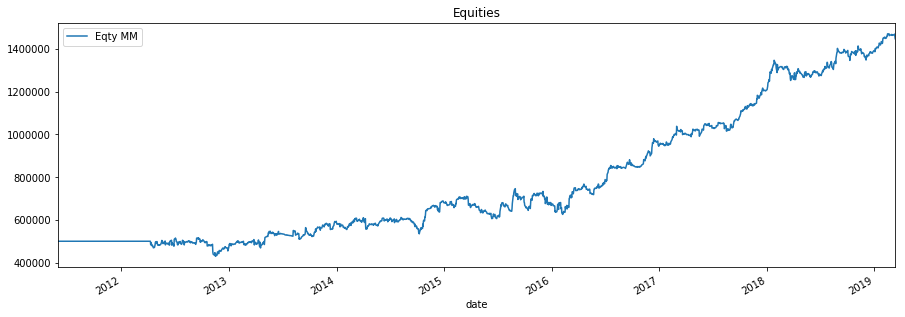

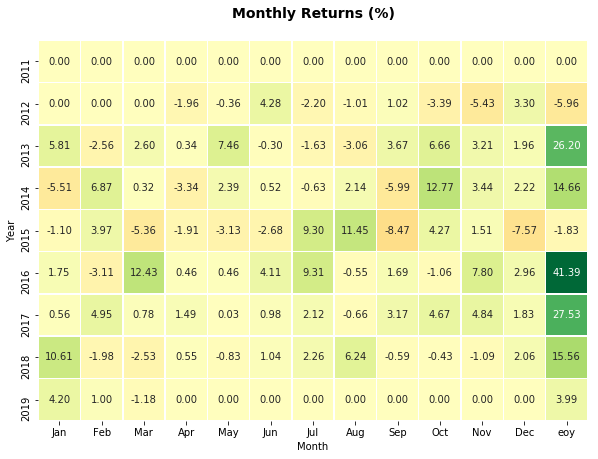

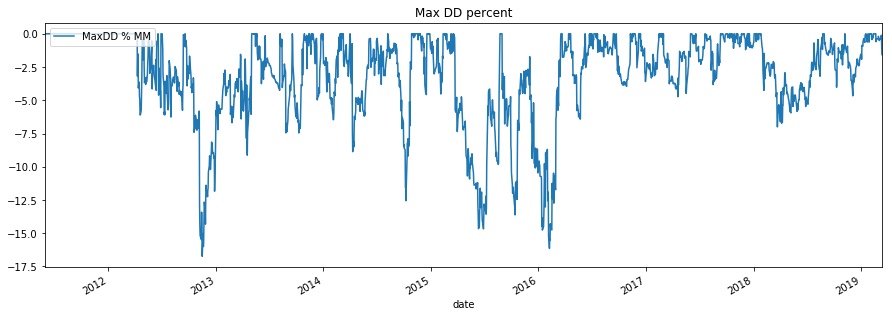

<Figure size 1080x360 with 0 Axes>

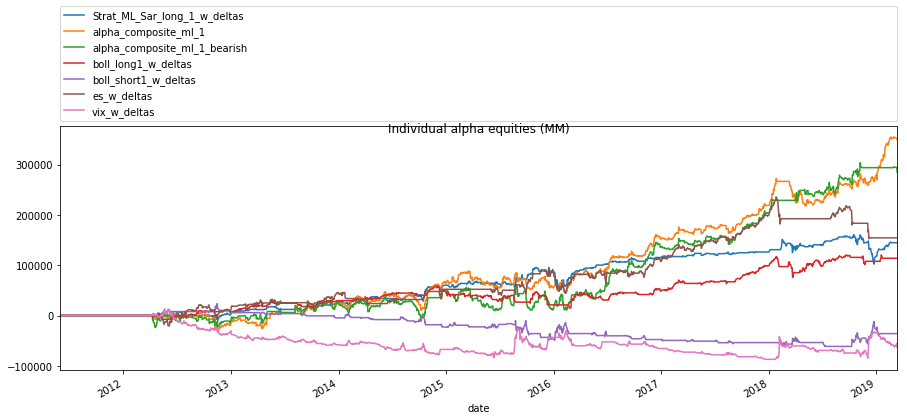

<Figure size 1080x360 with 0 Axes>

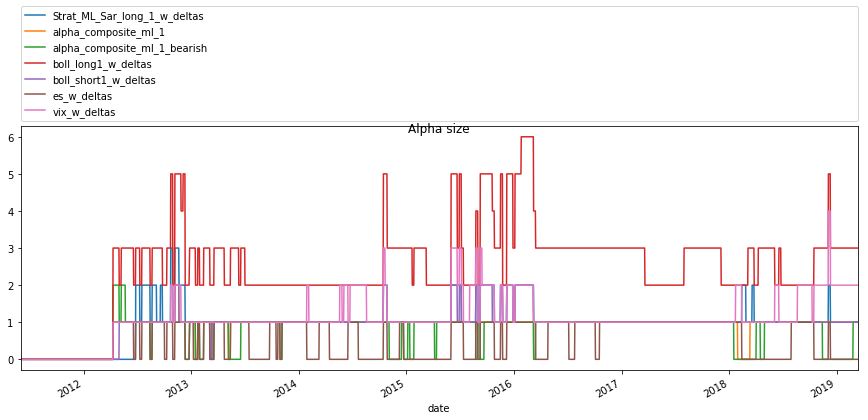

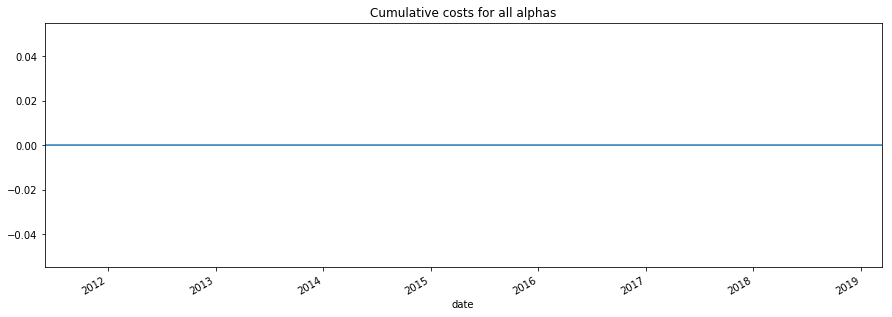

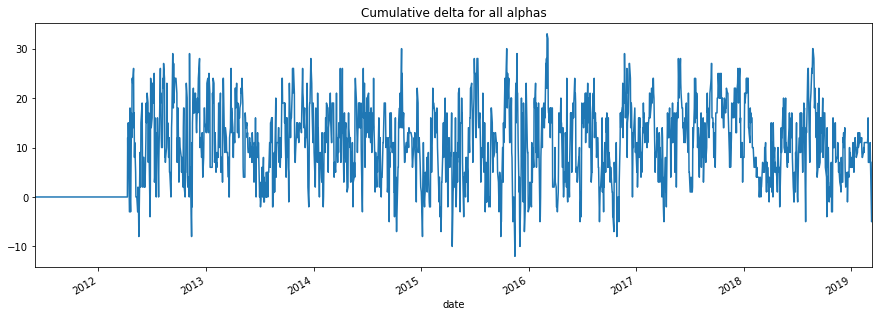

In [165]:
## figsize(15, 5)
scmp.report(bt_dict)

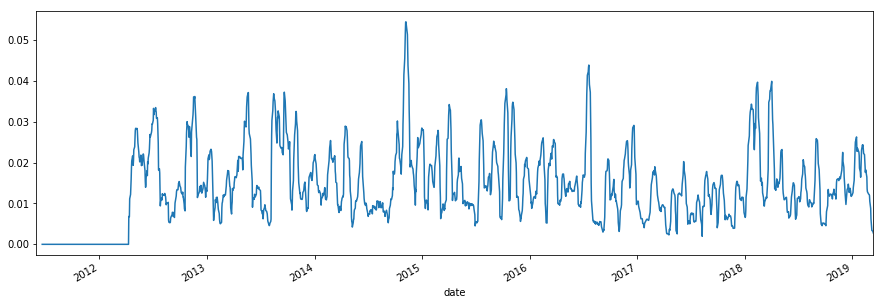

In [141]:
(bt_dict['equity_mm'].rolling(15).std()/bt_dict['equity_mm']).plot()

In [10]:
import bt

comp = bt.merge(bt_dict['equity_mm'])

In [11]:
bt_dict['alphas_deltas_mm'].tail()

,Strat_ML_Sar_long_1_w_deltas,alpha_composite_ml_1,alpha_composite_ml_1_bearish,boll_long1_w_deltas,boll_short1_w_deltas,es_w_deltas,vix_w_deltas
date,,,,,,,
2019-03-07,0.0,6.0,3.0,0.0,0.0,3.0,10.0
2019-03-08,0.0,4.0,2.0,0.0,0.0,3.0,10.0
2019-03-11,0.0,-6.0,-6.0,0.0,0.0,3.0,10.0
2019-03-12,0.0,-4.0,-5.0,0.0,0.0,3.0,10.0
2019-03-13,6.0,2.0,1.0,0.0,0.0,3.0,10.0


In [12]:
bt_dict.keys()

dict_keys(['alphas_equity_mm', 'initial_capital', 'alphas_contracts_mm', 'campaign_alphas_size', 'alphas_costs_mm', 'equity_mm', 'rfr', 'alphas_deltas_mm'])

In [166]:
bt_dict['equity_mm'].to_csv('inv_150_bi_leg.csv')

In [14]:
bt_dict['alphas_deltas_mm'].to_csv('lbi_leg_deltas.csv')